# Model proto

This is a rough prototype of our RL solution

In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import time
import sys

if '..' not in sys.path: sys.path.append('..')
from src.utils import *
from src.actions import *
from src.units import *
from src.game_utils import *
from src.agent import DnDAgent
from src.game_board import DnDBoard

## Sample agent game

In [2]:
agent = DnDAgent(lr=0.001, board_shape=(5, 5), epsilon_delta=1e-6, in_channels=7, out_actions=2, batch_size=128)
iters, eps, checkpoints = [], [], []

In [3]:
def create_same_game(board_size = (5, 5), show_game=False, get_colormap=True):
    game = DnDBoard(board_size)

    ally = GenericSoldier("Ally soldier", health=100, attack_damage=25, speed=2, range=2)
    #ally2 = GenericSoldier("Ally archer", health=50, attack_damage=25, speed=4, range=8)
    enemy = GenericSoldier("Enemy soldier", health=100, attack_damage=25, speed=2, range=2)
    #enemy2 = GenericSoldier("Enemy archer", health=50, attack_damage=25, speed=4, range=8)
    
    place_unit_randomly(game, ally, 0)
    place_unit_randomly(game, enemy, 1)
    #place_unit_randomly(game, ally2, 0)
    #place_unit_randomly(game, enemy2, 1)
   
    game.initialize_game()

    if get_colormap or show_game:
        color_map = {
            ally: "Green",
            enemy: "Red",
            #ally2: "Blue",
            #enemy2: "Purple"
        }

        if show_game: print_game(game, color_map)

        return game, color_map

    return game

In [4]:
def self_play_loop(game, color_map, delay=0.5):
    game_over = False
    iter_count = 0

    print_game(game, color_map)
    
    while not game_over:
        try:
            iter_count += 1

            time.sleep(delay)
            clear_output(wait=True)
            print(f'Iteration: {iter_count}')

            state = game.observe_board()
            new_coords, action, _ = agent.choose_action(game, state)

            _, game_over = take_turn(game, new_coords, action, color_map, True)
        except KeyboardInterrupt:
            print(f'\nGame interrupted after {iter_count} iterations')
            return None

    print(f'\nGame over in {iter_count} iterations. Current epsilon = {agent.epsilon}')

    return iter_count

In [5]:
# agents do not get punished for losing
# next state is the state right after agent's move
def train_loop_trivial(agent: DnDAgent, game: DnDBoard) -> int:
    game_over = False
    iter_count = 0
    
    while not game_over:
        iter_count += 1
    
        state = game.observe_board()
        new_coords, action, action_tuple = agent.choose_action(game, state)

        reward, game_over = game.take_turn(new_coords, action, skip_illegal=True)
        new_state = game.observe_board()

        agent.memorize(state, action_tuple, reward, new_state, game_over)
        agent.learn()

    return iter_count

In [6]:
# next state is delayed and can be inconsistent. Enemy reward is your punishment
def train_loop_delayed(agent: DnDAgent, game: DnDBoard) -> int:
    game_over = False
    iter_count = 0
    
    last_state, last_reward, last_action = None, None, None
    while not game_over:
        iter_count += 1
    
        state = game.observe_board()
        new_coords, action, action_tuple = agent.choose_action(game, state)
    
        reward, game_over = game.take_turn(new_coords, action, skip_illegal=True)
        new_state = game.observe_board()

        ## THIS IS WRONG, FIX REWARD
        if last_state is not None:
            total_reward = last_reward - reward
            agent.memorize(last_state, last_action, total_reward, new_state, game_over)
            
        if game_over:
            agent.memorize(state, action_tuple, reward, new_state, game_over)
        
        agent.learn()
        last_state = state
        last_action = action_tuple
        last_reward = reward

    return iter_count

In [7]:
train_loop = train_loop_delayed # this one is actually bugged

In [8]:
games = 50
checkpoint_each = 10
checkpoint_name = 'checkpoint'

last_checkpoint = checkpoints[-1] if len(checkpoints) > 0 else 0
with tqdm(range(games), desc='Training') as pbar:
    for i in pbar:
        game = create_same_game(get_colormap=False)
        iter_count = train_loop(agent, game)
        iters.append(iter_count)
        eps.append(agent.epsilon)

        iter_i = len(iters)
        if iter_i - last_checkpoint >= checkpoint_each:
            last_checkpoint = iter_i
            checkpoints.append(iter_i)
            agent.save_agent(f'../checkpoints/{checkpoint_name}-{iter_i}')

Training:   0%|          | 0/50 [00:00<?, ?it/s]

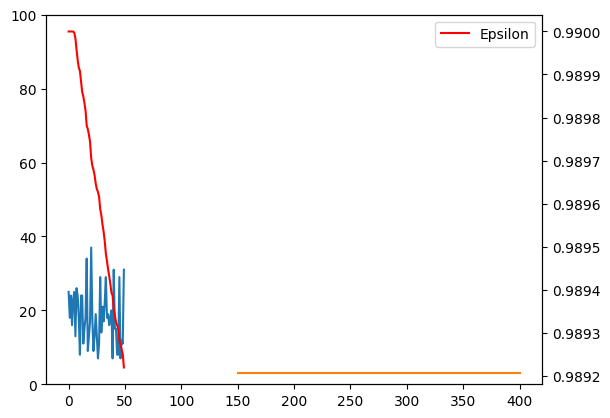

In [9]:
start_from = 0000

itersl = iters[start_from:]
n = 300
plt.plot(itersl, label='Iterations per game')
smooth = np.convolve(itersl, np.ones(n) / n, mode='valid')
plt.plot(range(n // 2, len(smooth) + n // 2), smooth, label='Smoothed')
plt.ylim(0, 100)
ax2 = plt.twinx()
ax2.plot(eps[start_from:], color='red', label='Epsilon')
plt.legend()
plt.show()

In [10]:
agent.save_agent('../checkpoints/test/')

In [11]:
game, color_map = create_same_game()
epsilon = agent.epsilon
agent.epsilon = 0
self_play_loop(game, color_map, delay=1)
agent.epsilon = epsilon

Iteration: 7
Turn made by player #1: `Enemy soldier`:
	Unit does not move: (2, 0) -> (2, 0);
	And takes aciton `Sword attack` with attributes: {'source_unit': 'Enemy soldier', 'target_unit': 'None'}

Units alive: 2
Players: 2:
	Player #0 (1 units): `Ally soldier (100 HP)`  
	Player #1 (1 units): `Enemy soldier (100 HP)`  
	
    0 1 2 3 4
 0            0 
 1            1 
 2 ██         2 
 3            3 
 4     ██     4 
    0 1 2 3 4

Next move is by player #0: `Ally soldier`

Game interrupted after 8 iterations


# Visualization

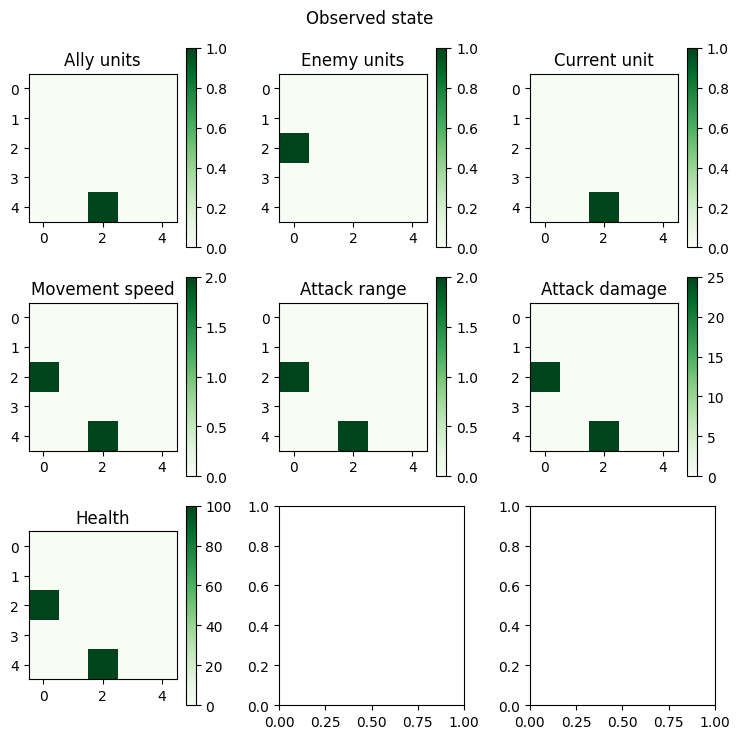

In [12]:
state = game.observe_board()
plot_featuremaps(
    state, 
    title='Observed state', 
    fm_names=['Ally units', 'Enemy units', 'Current unit', 'Movement speed', 'Attack range', 'Attack damage', 'Health'],
    vmin = -3,
    vmax = 3,
    separate_cbars=True,
    cmap='Greens'
)

In [13]:
game, color_map = create_same_game()
agent.game = game
print_game(game, color_map)

Units alive: 2
Players: 2:
	Player #0 (1 units): `Ally soldier (100 HP)`  
	Player #1 (1 units): `Enemy soldier (100 HP)`  
	
    0 1 2 3 4
 0            0 
 1            1 
 2       ██   2 
 3            3 
 4         ██ 4 
    0 1 2 3 4

Next move is by player #1: `Enemy soldier`


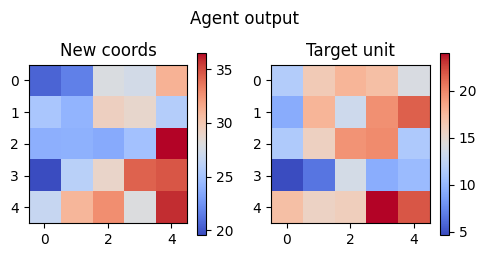

((2, 1), (4, 4))


In [14]:
state = game.observe_board()
output = agent.predict(state)

plot_featuremaps(
    output, 
    title='Agent output', 
    fm_names=['New coords', 'Target unit'],
    separate_cbars=True
)

print(agent.choose_action(game, state)[2])